# Evaluation

## Preliminaries

### Imports

In [1]:
import sys
import os
sys.path.append('./src')

In [2]:
import pandas as pd

In [3]:
from programmable_chatbot.chatbot_api import Chatbot

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

### Constants

In [5]:
DATA_PATH = '../resources/data/eval'
DIALOGUE_PATHS = {
    'Therapy-DLDLM': '../../dldlm/resources/data/cache/therapy_dldlm_empathy_assessment_samples.csv',
    'GS-DLM': '../../gibbstransformers/resources/data/cache/gs_dlm_empathy_assessment_samples.csv',
    'PPM-DLM': '../resources/data/cache/ppm_dlm_empathy_assessment_samples.csv'
}

if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)

In [6]:
TOKENIZER = 'gpt2'
MODEL_PATH = '../experiments/PROGCHAT/gpt2_large_2023_01_06_12_19_33/model/best_checkpoint'

In [7]:
IN_DF_COLUMNS = ['Split', 'Corpus', 'Conversation ID', 'Turn IDX', 'Speaker', 'Context', 'Last message', 'Response', 'Model']
OUT_DF_COLUMNS = IN_DF_COLUMNS + ['Emotional reaction', 'Exploration', 'Interpretation']

### Model and tokenizer

In [8]:
chatbot = Chatbot(
    MODEL_PATH,
    TOKENIZER
)

## Data

### Load data

In [9]:
data = {k: pd.read_csv(v) for k, v in DIALOGUE_PATHS.items()}

## Task description

In [10]:
preamble = 'The following is an exchange of messages on an online mental health support' \
           'forum between a person, called User, and a therapist, called Supporter.'


labels = {
    'Emotional reaction': (
        'Label the following response of a conversation with information about the emotional reaction.\n'
        'Emotional reaction is a communication mechanism of empathy. '
        'Having an emotional reaction means expressing emotions such as warmth, compassion, and concern. '
        'Expressing these emotions plays an important role in establishing empathetic rapport and support.\n'
        'The values of emotional reaction are: no communication, weak communication, strong communication.',
        ['no communication', 'weak communication', 'strong communication']
    ),
    'Exploration': (
        'Label the following response of a conversation with information about the exploration.\n'
        'Exploration is a communication mechanism of empathy.'
        'It consists in improving understanding of the other by exploring the feelings '
        'and experiences not directly stated. Showing an active interest in what the other '
        'is experiencing and feeling and probing gently is another important aspect of empathy.\n'
        'The values of exploration are: no communication, weak communication, strong communication.',
        ['no communication', 'weak communication', 'strong communication']
    ),
    'Interpretation': (
        'Label the following response of a conversation with information about the interpretation.\n'
        'Interpretation is a communication mechanism of empathy. '
        'Interpretation consists in communicating an understanding of feelings and experiences '
        'inferred from the interaction with the other. Such a cognitive understanding in responses '
        'is helpful in increasing awareness of hidden feelings and experiences, '
        'and essential for developing alliance between two interacting\n'
        'The values of interpretation are: no communication, weak communication, strong communication.',
        ['no communication', 'weak communication', 'strong communication']
    )
}

## Evaluation data preparation

### Responses generation

In [11]:
out_data = {}

In [12]:
# Iterate over dialogues
for key, df in data.items():
    df['Last message'] = df['Last message'].fillna('')
    # Iterate over labels to assign
    for label, (labelling_task, label_values) in labels.items():
        # Create accumulator for predicted values
        values = []
        # Iterate over DF rows
        for _, row in df.iterrows():
            # Get prediction
            values.append(chatbot.label_utterance(
                [row['Last message'].replace('Client', 'User')] if row['Last message'] != '' else [], row['Response'].replace('Therapist', 'Supporter'), label, label_values,
                'posterior', f'{preamble}\n\n{labelling_task}'
            ))
        # Add values to data frame
        df[label] = values
    # Add values to accumulator
    out_data[key] = df
    # Serialise results
    df.to_csv(
        os.path.join(DATA_PATH, f'empathy_results_{key.lower().replace(" ", "_").replace("-", "_")}.csv'), index=False
    )

### Visualise results

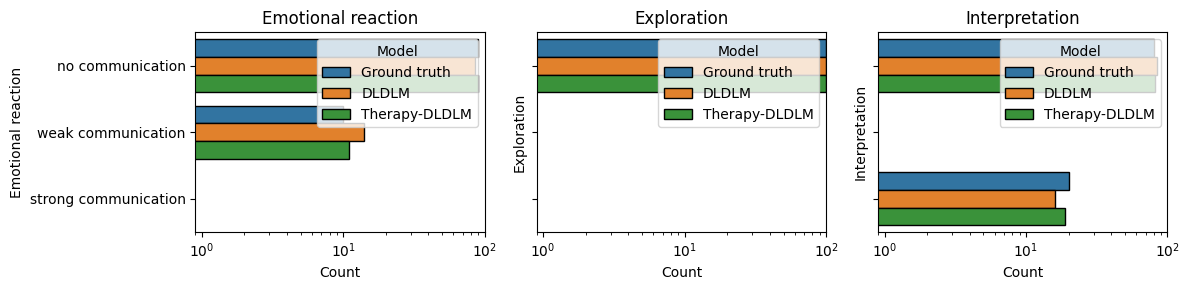

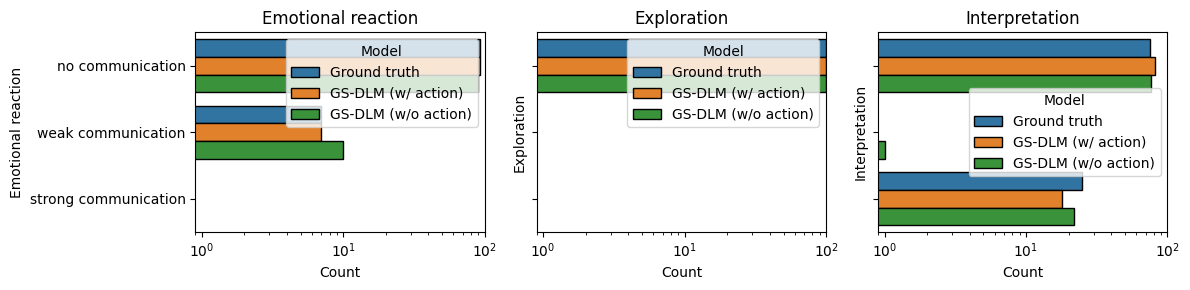

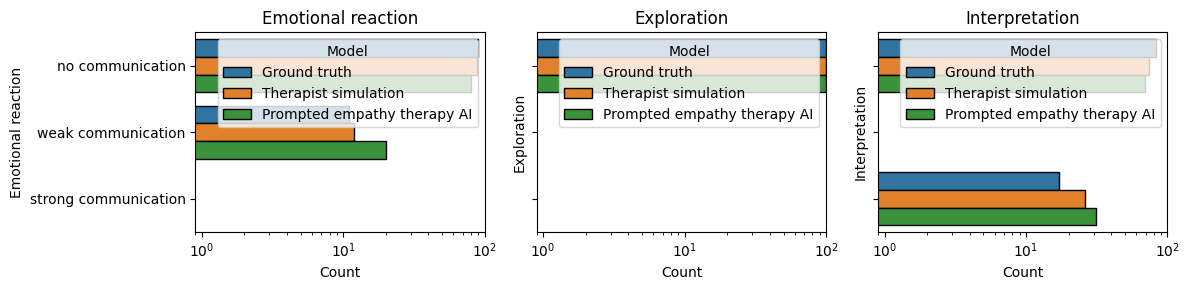

In [13]:
for key, df in out_data.items():
    fig, axes = plt.subplots(
        nrows=1,
        ncols=3,
        figsize=(12, 3),
        sharex=True,
        sharey=True
    )

    for i, label in enumerate(labels):
        sns.countplot(
            data=df, hue='Model', y=label, order=labels[label][1], ax=axes[i], linewidth=1., edgecolor='0', orient='h'
        )
        axes[i].set_title(label)
        axes[i].set_xscale('log')
        axes[i].set_xlim([0.9, 100])
        axes[i].set_xlabel('Count')

        plt.tight_layout()
    plt.show()


    fig.savefig(
        os.path.join(DATA_PATH, f'empathy_results_{key.lower().replace(" ", "_").replace("-", "_")}.pdf'),
        bbox_inches='tight'
    )
